In [7]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import datetime
import missingno
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

This is the dataset I selected to talk about to an non-technical audience. It is a dataset that tracks the prices of a number of basic foodstuffs and other goods in developing countries, it comes from the world food programme.

In [8]:
food_prices = pd.read_csv('E:\\OtherCodeProjects\\Springboard Capstone Projects\\Springboard-Capstone-2-Data\\global_food_prices_f.csv')
food_prices['date'] = pd.to_datetime(food_prices['date'])
food_prices.head()

C:\Users\William\AppData\Local\Temp\ipykernel_6004\4102450621.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  food_prices = pd.read_csv('E:\\OtherCodeProjects\\Springboard Capstone Projects\\Springboard-Capstone-2-Data\\global_food_prices_f.csv')


,adm0_id,adm0_name,adm1_id,adm1_name,mkt_id,mkt_name,cm_id,cm_name,cur_name,pt_id,pt_name,um_id,um_name,mp_price,date,days
0,1.0,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread - Retail,AFN,15,Retail,5,KG,50.0,2014-01-01,16071
1,1.0,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread - Retail,AFN,15,Retail,5,KG,50.0,2014-02-01,16102
2,1.0,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread - Retail,AFN,15,Retail,5,KG,50.0,2014-03-01,16130
3,1.0,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread - Retail,AFN,15,Retail,5,KG,50.0,2014-04-01,16161
4,1.0,Afghanistan,272,Badakhshan,266,Fayzabad,55,Bread - Retail,AFN,15,Retail,5,KG,50.0,2014-05-01,16191


For this project I'm interested in comparing two different countries, Niger and Afghanistan. What can we tell about these two countries just from looking at their food prices over time? And what methods of analysis might allow us to predict their food prices in the future?

This cell creates a function that can pull out one country and put it into a new dataframe that will make it easier to analyze

In [9]:
def create_avg_cm_df(initial_df):
    
    count = 0
    for cm_name in initial_df.cm_name.unique():

        df_avg = initial_df[initial_df['cm_name']==cm_name]
        df_avg = df_avg[['date', 'mp_price', 'days']]
        df_avg = df_avg.groupby(by='date').mean()
        df_avg.reset_index(inplace=True)
        df_avg['cm_name'] = cm_name
        df_avg = df_avg.pivot_table(values='mp_price', index=['date', 'days'], columns='cm_name')
        df_avg.reset_index(inplace=True)

        if count == 0:
            df_new = df_avg
        else:
            df_new = pd.merge(left=df_new, right=df_avg, on=['days', 'date'], how='outer')

        count += 1

    df_new.sort_values(by='days', inplace=True)
    df_new.reset_index(inplace=True, drop=True)
    #df_new.set_index('days', verify_integrity=True, inplace=True)
    return df_new

The food prices just for Niger

In [10]:
NE_prices_avg = create_avg_cm_df(food_prices[food_prices['adm0_name']=='Niger'])
NE_prices_avg.head()

cm_name,date,days,Maize - Retail,Rice (imported) - Retail,Sorghum - Retail,Millet - Retail,Beans (niebe) - Retail,Rice (imported) - Wholesale,Millet - Wholesale,Wheat - Retail,Sorghum (local) - Wholesale,Rice (local) - Retail
0,1990-01-01,7305.0,NaN,201.666667,57.750000,61.00,NaN,NaN,NaN,NaN,NaN,NaN
1,1990-02-01,7336.0,NaN,201.666667,54.250000,63.40,NaN,NaN,NaN,NaN,NaN,NaN
2,1990-03-01,7364.0,NaN,201.666667,54.750000,65.20,NaN,NaN,NaN,NaN,NaN,NaN
3,1990-04-01,7395.0,NaN,202.333333,55.500000,69.60,NaN,NaN,NaN,NaN,NaN,NaN
4,1990-05-01,7425.0,NaN,202.333333,49.666667,63.25,NaN,NaN,NaN,NaN,NaN,NaN


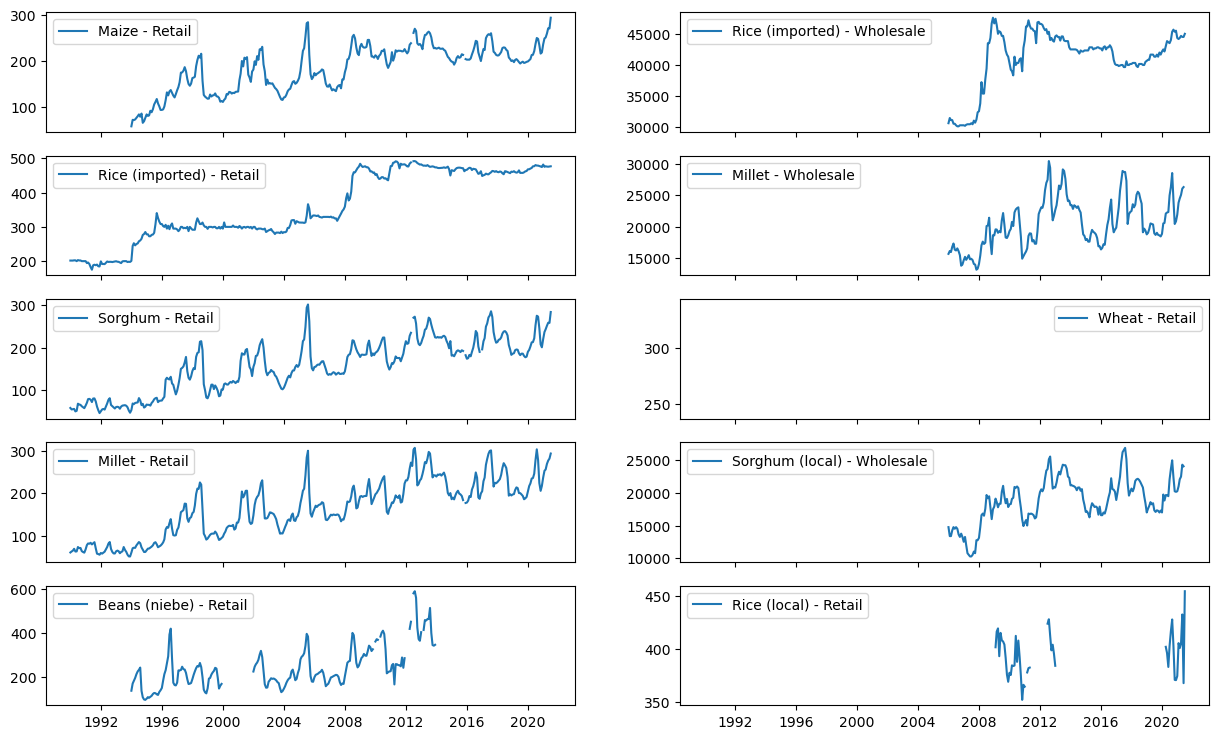

In [11]:
fig, ax = plt.subplots(5, 2, sharex=True)

fig.set_size_inches(15, 9)

ax[0,0].plot(NE_prices_avg.date, NE_prices_avg['Maize - Retail'], label='Maize - Retail')
ax[0,0].legend()
ax[1,0].plot(NE_prices_avg.date, NE_prices_avg['Rice (imported) - Retail'], label='Rice (imported) - Retail')
ax[1,0].legend()
ax[2,0].plot(NE_prices_avg.date, NE_prices_avg['Sorghum - Retail'], label='Sorghum - Retail')
ax[2,0].legend()
ax[3,0].plot(NE_prices_avg.date, NE_prices_avg['Millet - Retail'], label='Millet - Retail')
ax[3,0].legend()
ax[4,0].plot(NE_prices_avg.date, NE_prices_avg['Beans (niebe) - Retail'], label='Beans (niebe) - Retail')
ax[4,0].legend()
ax[0,1].plot(NE_prices_avg.date, NE_prices_avg['Rice (imported) - Wholesale'], label='Rice (imported) - Wholesale')
ax[0,1].legend()
ax[1,1].plot(NE_prices_avg.date, NE_prices_avg['Millet - Wholesale'], label='Millet - Wholesale')
ax[1,1].legend()
ax[2,1].plot(NE_prices_avg.date, NE_prices_avg['Wheat - Retail'], label='Wheat - Retail')
ax[2,1].legend()
ax[3,1].plot(NE_prices_avg.date, NE_prices_avg['Sorghum (local) - Wholesale'], label='Sorghum (local) - Wholesale')
ax[3,1].legend()
ax[4,1].plot(NE_prices_avg.date, NE_prices_avg['Rice (local) - Retail'], label='Rice (local) - Retail')
ax[4,1].legend()

plt.show()

By plotting all of the food prices on one figure, we can see a number of things. Firstly, the graphs on the right side are very incomplete, probably too incomplete to get any useful information out of. Secondly, many of the locally grown crops (Millet, Sorghum, Maize) have very simmilarly shaped graphs! Their prices seem highly correlated, which makes sense, as the enviornmental and economic factors that effect one local crop will probably affect the others. In contract, the plot for the imported rice is much flatter and with less obvious seasonality. The price of imported rice is not impacted by local conditions as much and is more consistent. 

<AxesSubplot:xlabel='date'>

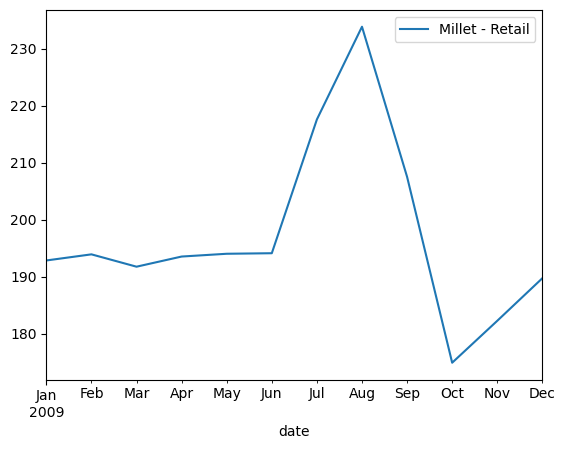

In [12]:
NE_Millet_avg_2009 = NE_prices_avg[NE_prices_avg['date'].dt.year == 2009]
NE_Millet_avg_2009.plot(x='date', y='Millet - Retail')

Zooming in on one year, we can see that the seasonal component to the millet price. In Niger, it looks like the price is highest in the summer and lower in the winter, presumably when the crop is harvested. But this is just one year, can we break down the components of this time-series to better see what's going on?

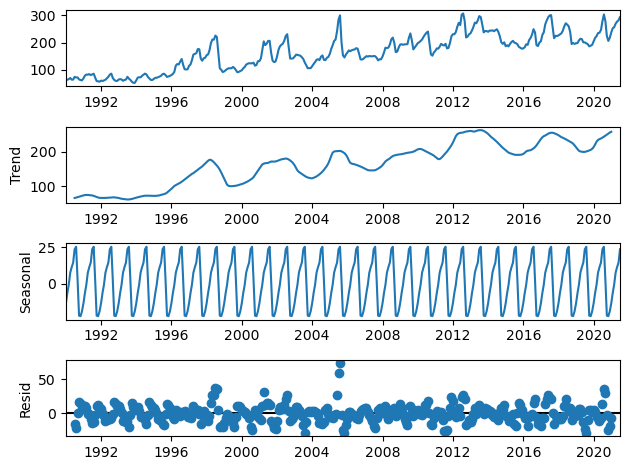

In [14]:
#Filling in NaN values
to_interpolate = ['Millet - Retail', 'Sorghum - Retail', 'Rice (imported) - Retail', 'Maize - Retail']
NE_prices_avg[to_interpolate] = NE_prices_avg[to_interpolate].interpolate(method='linear')

#Creating a time series of just millet prices
millet_ts = NE_prices_avg[['Millet - Retail', 'date']]
millet_ts.set_index('date', inplace=True)

#Creating a seasonal decomposition
decomp = seasonal_decompose(millet_ts)
decomp.plot()
plt.show()

This seasonal decomposition breaks down the components of our millet price time series. The top chart is the unaltered time series, while the next one down is the overall trend. As you can see, the trend steadily increases over time with inflation, with some hills and valleys disrupting it. The next plot down is the seasonality component of the time-series. Here, we can see prices are regularly lower in the winter and higher in the summer, as we had guessed above. Finally, the last plot is the residuals. If the time series were perfectly explained by the seasonality and trend, we'd expect this to be random dots clustered around zero, but that isn't the case! We can see a number of dots clearly above zero, especially around 2006. Being able to predict these out of the ordinary events would be very valuable, but clearly we are missing some information.

How does this compare to the data from Afghanistan?

In [15]:
AF_prices_avg = create_avg_cm_df(food_prices[food_prices['adm0_name']=='Afghanistan'])
AF_prices_avg.head()

cm_name,date,days,Bread - Retail,Wheat - Retail,Rice (low quality) - Retail,Wage (qualified labour) - Retail,"Livestock (sheep, one-year-old alive female) - Retail",Fuel (diesel) - Retail,Exchange rate - Retail,"Wage (non-qualified labour, non-agricultural) - Retail",Oil (cooking) - Retail,Sugar - Retail,Pulses - Retail,Wheat flour (high quality) - Retail,Salt - Retail,Rice (high quality) - Retail,Wheat flour (low quality) - Retail,Wheat flour - Retail
0,2000-01-01,10957.0,15.2500,12.2300,NaN,NaN,NaN,NaN,NaN,83124.916667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.5450
1,2000-02-01,10988.0,15.3000,11.7475,NaN,NaN,NaN,NaN,NaN,85833.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.4275
2,2000-03-01,11017.0,14.7525,10.9300,NaN,NaN,NaN,25091.650000,NaN,82569.416667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.1550
3,2000-04-01,11048.0,17.1950,13.1425,NaN,NaN,NaN,22223.133333,NaN,87722.200000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.3450
4,2000-05-01,11078.0,18.2775,12.6475,NaN,NaN,1.214583e+06,22813.916667,NaN,89166.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.2450


In [17]:
AF_prices_avg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259 entries, 0 to 258
Data columns (total 18 columns):
 #   Column                                                  Non-Null Count  Dtype         
---  ------                                                  --------------  -----         
 0   date                                                    259 non-null    datetime64[ns]
 1   days                                                    259 non-null    float64       
 2   Bread - Retail                                          258 non-null    float64       
 3   Wheat - Retail                                          258 non-null    float64       
 4   Rice (low quality) - Retail                             172 non-null    float64       
 5   Wage (qualified labour) - Retail                        85 non-null     float64       
 6   Livestock (sheep, one-year-old alive female) - Retail   32 non-null     float64       
 7   Fuel (diesel) - Retail                                  143 no

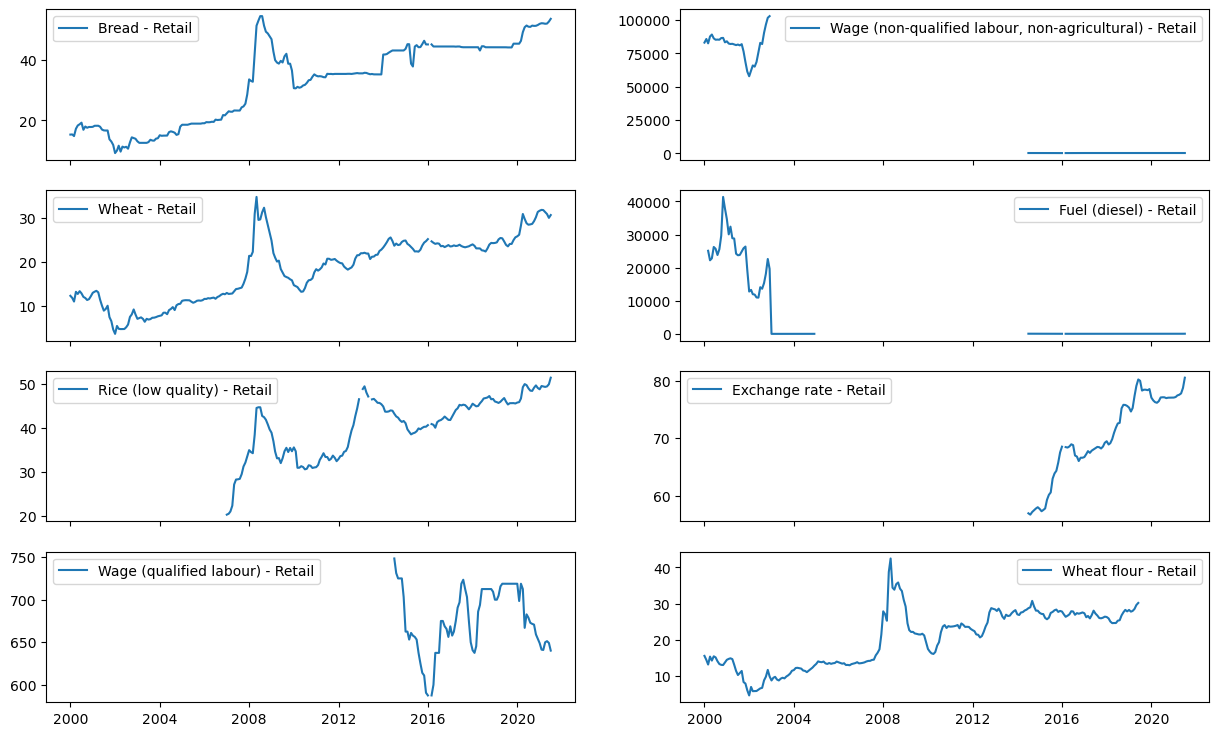

In [21]:
fig, ax = plt.subplots(4, 2, sharex=True)

fig.set_size_inches(15, 9)

ax[0,0].plot(AF_prices_avg.date, AF_prices_avg['Bread - Retail'], label='Bread - Retail')
ax[0,0].legend()
ax[1,0].plot(AF_prices_avg.date, AF_prices_avg['Wheat - Retail'], label='Wheat - Retail')
ax[1,0].legend()
ax[2,0].plot(AF_prices_avg.date, AF_prices_avg['Rice (low quality) - Retail'], label='Rice (low quality) - Retail')
ax[2,0].legend()
ax[3,0].plot(AF_prices_avg.date, AF_prices_avg['Wage (qualified labour) - Retail'], label='Wage (qualified labour) - Retail')
ax[3,0].legend()
ax[0,1].plot(AF_prices_avg.date, AF_prices_avg['Wage (non-qualified labour, non-agricultural) - Retail'], label='Wage (non-qualified labour, non-agricultural) - Retail')
ax[0,1].legend()
ax[1,1].plot(AF_prices_avg.date, AF_prices_avg['Fuel (diesel) - Retail'], label='Fuel (diesel) - Retail')
ax[1,1].legend()
ax[2,1].plot(AF_prices_avg.date, AF_prices_avg['Exchange rate - Retail'], label='Exchange rate - Retail')
ax[2,1].legend()
ax[3,1].plot(AF_prices_avg.date, AF_prices_avg['Wheat flour - Retail'], label='Wheat flour - Retail')
ax[3,1].legend()

plt.show()

PLotting the data, we can see that again, much of it is too incomplete to make much of an analysis from. Of the food prices that are more complete, however, again the seem fairly correlated, but not as correlated as before! Rice has a large spike ~2013 that the others do not, and bread in particular seems very smooth and unseasonal. These foods look more like the imported rice graph from Niger, and my hypothesis is that Afghanistan imports much more of its food than does Niger and the prices are therefore less seasonal and the spikes are less predictable. 

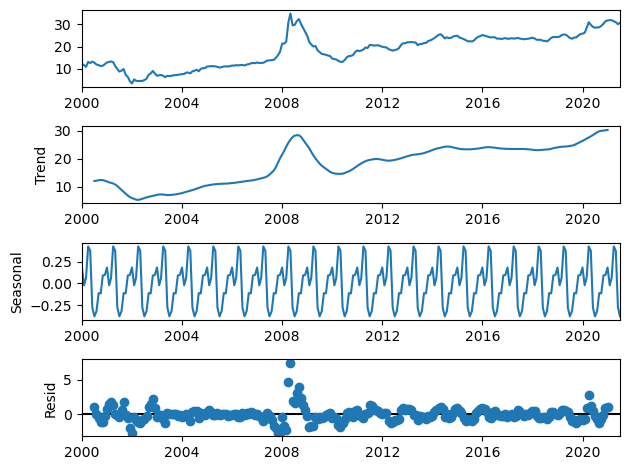

In [23]:
AF_prices_avg['Wheat - Retail'] = AF_prices_avg['Wheat - Retail'].interpolate(method='linear')
wheat_ts = AF_prices_avg[['Wheat - Retail', 'date']]
wheat_ts.set_index('date', inplace=True)
decomp = seasonal_decompose(wheat_ts)
decomp.plot()
plt.show()

Taking a look at the seasonal decomposition shows that there is still a seasonal component, although it is weaker and less regular than it was for Niger. Again there is also a large resudual spike beginning around 2008, so somefactors relating to food prices are still missing from the data. 

In conclusion, it should be possible to predict food price changes in these developing countries, but looking just at previous time series data will probably not be enough, as both had large residual components that would not be accounted for. However, the additional data that is needed is probably very different for both countries. For Niger, a country that grows much of its own food and is very reliant on the local seasons, gathering historical climatic data may be very predictive. Afghanistan, though, imports much of its food and is much less reliant on the local seasons. Predicting unusual price spikes in Afghanistan may require harder to quantify factors, like levels of violence in the country or interruptions in food aid to the country.